In [2]:
import gc
import os

import scipy
from scipy.io import netcdf_file

os.environ["CDF_LIB"] = "~/CDF/lib"
import datetime
import glob
import pickle

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacepy
from spacepy import pycdf
from tqdm import tqdm
from scipy.stats import gaussian_kde
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as grid_spec
import warnings
warnings.filterwarnings('ignore')



In [3]:
twins_dir = '../data/twins/'
supermag_dir = '../data/supermag/'
regions_dict = '../identifying_regions/outputs/twins_era_identified_regions_min_2.pkl'
regions_stat_dict = '../identifying_regions/outputs/twins_era_stats_dict_radius_regions_min_2.pkl'


region_numbers = [83, 143, 223, 44, 173, 321, 366, 383, 122, 279, 14, 95, 237, 26, 166, 86,
						387, 61, 202, 287, 207, 361, 137, 184, 36, 19, 9, 163, 16, 270, 194, 82,
						62, 327, 293, 241, 107, 55, 111]

In [4]:
times = pd.read_feather('outputs/regular_twins_map_dates.feather')

In [5]:
with open(regions_dict, 'rb') as f:
	regions = pickle.load(f)

regions = {f'region_{reg}': regions[f'region_{reg}'] for reg in region_numbers}

with open(regions_stat_dict, 'rb') as g:
	stats = pickle.load(g)

stats = {f'region_{reg}': stats[f'region_{reg}'] for reg in region_numbers}

In [6]:
def combining_regional_dfs(stations, rsd):

	start_time = pd.to_datetime('2010-01-01')
	end_time = pd.to_datetime('2017-12-31')
	twins_time_period = pd.date_range(start=start_time, end=end_time, freq='min')

	combined_stations = pd.DataFrame(index=twins_time_period)

	for station in stations:
		stat = loading_supermag(station, start_time, end_time)
		combined_stations = pd.concat([combined_stations, stat['dbht']], axis=1, ignore_index=False)


	mean_dbht = combined_stations.mean(axis=1)
	max_dbht = combined_stations.max(axis=1)

	combined_stations['reg_mean'] = mean_dbht
	combined_stations['reg_max'] = max_dbht
	combined_stations['rsd'] = rsd['max_rsd']
	combined_stations['MLT'] = rsd['MLT']

	return combined_stations

def loading_supermag(station, start_time, end_time):

	df = pd.read_feather(supermag_dir+station+'.feather')

	# limiting the analysis to the nightside
	df.set_index('Date_UTC', inplace=True, drop=True)
	df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:$S')
	df = df[start_time:end_time]

	return df

In [7]:
dataframes = []

for region in regions.keys():
	df = combining_regional_dfs(regions[region]['station'], stats[region]['max_rsd'])
	dataframes.append(df)

In [8]:
df = dataframes[27]
limit = 80
strt = limit-20
print(df['2010-05-04 09:40:00':'2010-05-04 11:40:00']['MLT'][strt:limit])


2010-05-04 10:40:00    23.770000
2010-05-04 10:41:00    23.779999
2010-05-04 10:42:00    23.799999
2010-05-04 10:43:00    23.815001
2010-05-04 10:44:00    23.830000
2010-05-04 10:45:00    23.849998
2010-05-04 10:46:00    23.865000
2010-05-04 10:47:00    23.879999
2010-05-04 10:48:00    23.895000
2010-05-04 10:49:00    23.910000
2010-05-04 10:50:00    23.930000
2010-05-04 10:51:00    23.940001
2010-05-04 10:52:00    23.959999
2010-05-04 10:53:00    23.975000
2010-05-04 10:54:00    23.990000
2010-05-04 10:55:00     0.010000
2010-05-04 10:56:00     0.020000
2010-05-04 10:57:00     0.040000
2010-05-04 10:58:00     0.055000
2010-05-04 10:59:00     0.070000
Freq: T, Name: MLT, dtype: float32


In [9]:
times = pd.to_datetime(times['dates'], format='%Y-%m-%d %H:%M:%S')

twins_files = sorted(glob.glob(twins_dir+'*.cdf', recursive=True))

maps = {}
maps_array = []

for file in twins_files:
	twins_map = pycdf.CDF(file)
	for i, date in enumerate(twins_map['Epoch']):
		check = pd.to_datetime(date.strftime(format='%Y-%m-%d %H:%M:%S'), format='%Y-%m-%d %H:%M:%S')
		if check in times.values:
			maps[check.round('T').strftime(format='%Y-%m-%d %H:%M:%S')] = twins_map['Ion_Temperature'][i][50:140,40:100]
			maps_array.append(twins_map['Ion_Temperature'][i][50:140,40:100])

In [10]:
for arr in maps_array:
	arr[arr ==-1] = np.nan

In [11]:
alg_maps = []
for arr in maps_array:
	alg_maps.append((arr-np.nanmean(arr)) / np.nanstd(arr))

Mean: 7.334639030624031
StD: 1.477310327906618
Var: 2.182445804939559
Min: 4.624611143114628
Max: 12.889598082363515
2010-04-04 22:00:00                                             0.395019
2010-04-04 22:01:00                                             0.283649
2010-04-04 22:02:00                                             0.415668
2010-04-04 22:03:00                                             0.553461
2010-04-04 22:04:00                                             0.755948
                                             ...                        
2010-04-05 06:59:00                                             1.661423
2010-04-05 07:00:00                                              1.59353
polyx                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
polyy                  [0.39501894, 0.28364873, 0.41566843, 0.5534614...
poly                   [-1.1506559409722687e-127, 1.5324971046183638e...
Name: rsd, Length: 544, dtype: object


KeyError: 'polyx'

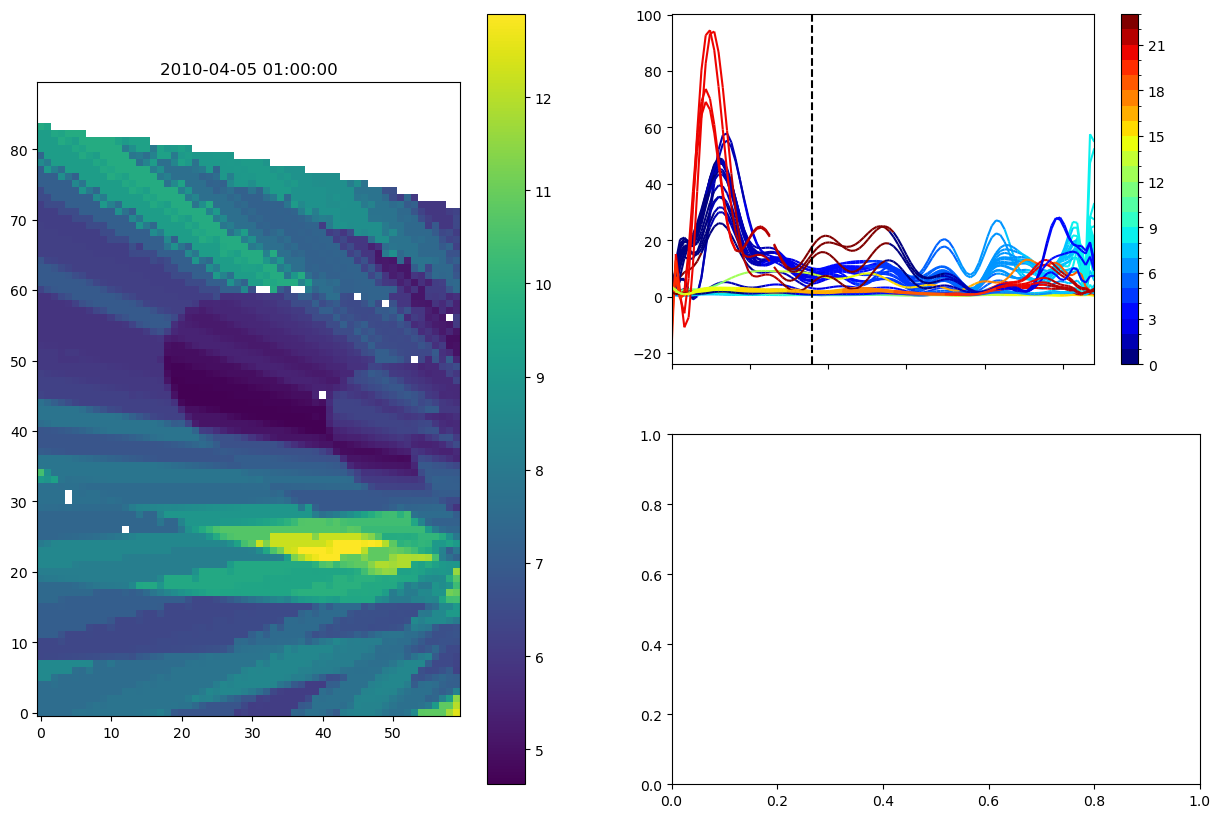

In [21]:
i = 1000
dbdt_degree = 50
rsd_degree = 50
hours_before = 3
hours_after = 6

print(f'Mean: {np.nanmean(maps_array[i])}')
print(f'StD: {np.nanstd(maps_array[i])}')
print(f'Var: {np.nanvar(maps_array[i])}')
print(f'Min: {np.nanmin(maps_array[i])}')
print(f'Max: {np.nanmax(maps_array[i])}')

dates = [date for date in maps.keys()]
dates = [pd.to_datetime(date, format='%Y-%m-%d %H:%M:%S') for date in dates]

fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(121)
plt.imshow(maps_array[i], origin='lower')
plt.title(dates[i])
plt.colorbar()

plot_start = dates[i] - pd.Timedelta(hours=hours_before)
plot_end = dates[i] + pd.Timedelta(hours=hours_after)
time_period = pd.date_range(start=plot_start, end=plot_end, freq='min')

colormap = plt.get_cmap('jet')
norm = BoundaryNorm([j for j in range(0,24)], colormap.N)

ax2 = plt.subplot(222)
# ax22 = ax2.twiny()
for df in dataframes:

	polyx = [n for n in range(len(df['reg_mean'][plot_start:plot_end]))]

	polyy = df['reg_mean'][plot_start:plot_end].values

	coeff = np.polyfit(polyx, polyy, dbdt_degree)

	poly = np.poly1d(coeff)

	x_fit = np.linspace(min(polyx), max(polyx), 100)
	y_fit = poly(x_fit)

	inxval = mdates.date2num(df['reg_mean'][plot_start:plot_end].index)
	# points = np.array([inxval, df['reg_mean'][plot_start:plot_end].values]).T.reshape(-1,1,2)
	points = np.array([x_fit, y_fit]).T.reshape(-1,1,2)
	segments = np.concatenate([points[:-1], points[1:]], axis=1)

	lc = LineCollection(segments, cmap=colormap, norm=norm)
	mlt_coloring_array = [df['MLT'][plot_start:plot_end][m] for m in range(0,len(polyx), int(len(polyx)/100))]
	lc.set_array(mlt_coloring_array)
	ax2.add_collection(lc)

ax2.set_xticklabels([])
ax2.autoscale_view()
plt.colorbar(lc)
plt.axvline(int((hours_before/(hours_before+hours_after))*len(time_period)), linestyle='--', color='black')
plt.margins(x=0)

ax4 = plt.subplot(224)
for df in dataframes:
	temp = df['rsd'][plot_start:plot_end].dropna(inplace=False)
	polyx = [n for n in range(len(temp))]

	polyy = temp.values

	try:
		coeff = np.polyfit(polyx, polyy, rsd_degree)
	except np.linalg.LinAlgError:
		coeff = np.polyfit(polyx, polyy, int(rsd_degree/2))


	poly = np.poly1d(coeff)

	temp_df = pd.DataFrame({'polyx': polyx,
							'polyy': polyy,
							'poly': poly},
							index=temp.index)
	print(temp)

	temp_df = pd.concat([temp_df, df[plot_start:plot_end].copy()], axis=1, ignore_index=False)
	# print(temp)

	x_fit = np.linspace(temp['polyx'].min(), temp['polyx'].max(), 100)
	y_fit = poly(x_fit)

	inxval = mdates.date2num(df['rsd'][plot_start:plot_end].index)
	# points = np.array([inxval, df['rsd'][plot_start:plot_end].values]).T.reshape(-1,1,2)
	points = np.array([x_fit, y_fit]).T.reshape(-1,1,2)
	segments = np.concatenate([points[:-1], points[1:]], axis=1)

	lc = LineCollection(segments, cmap=colormap, norm=norm)
	mlt_coloring_array = [df['MLT'][plot_start:plot_end][m] for m in range(0,len(temp), int(len(temp)/100))]
	lc.set_array(mlt_coloring_array)
	ax4.add_collection(lc)

x_ticks = [k for k in range(0, len(time_period), int((len(time_period)/len(ax4.get_xticklabels())))-1)]
ax4.set_xticklabels(time_period[x_ticks], rotation=45, ha='right')
ax4.autoscale_view()
plt.colorbar(lc)
plt.axvline(int((hours_before/(hours_before+hours_after))*len(time_period)), linestyle='--', color='black')
plt.margins(x=0)

plt.tight_layout()
plt.show()

/home/mcoughlan/anaconda3/envs/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


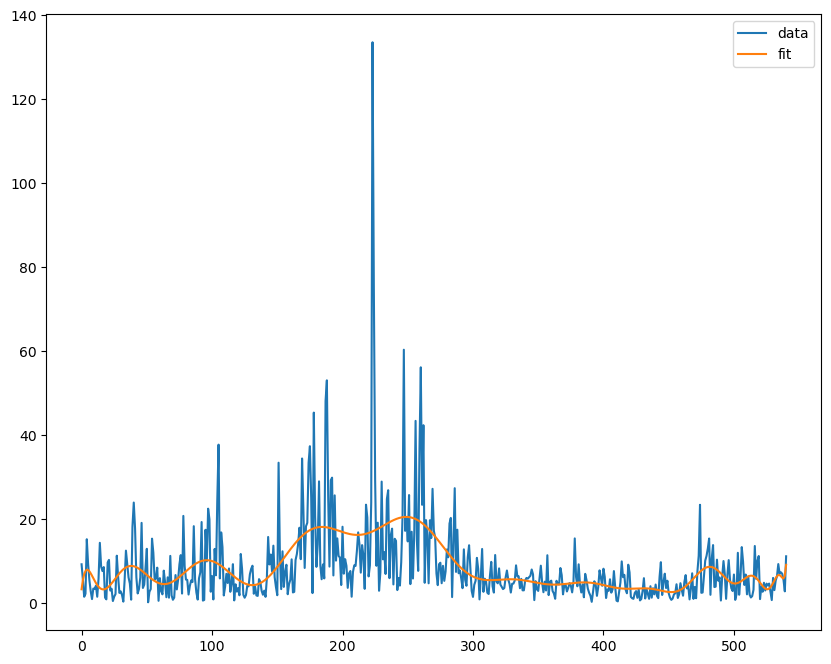

In [ ]:
polyx = [n for n in range(len(dataframes[27]['rsd'][plot_start:plot_end]))]
polyy = dataframes[27]['rsd'][plot_start:plot_end].values

degree = 111
coeff = np.polyfit(polyx, polyy, degree)

poly = np.poly1d(coeff)

x_fit = np.linspace(min(polyx), max(polyx), 500)
y_fit = poly(x_fit)

fig = plt.figure(figsize=(10,8))
plt.plot(polyx, polyy, label='data')
plt.plot(x_fit, y_fit, label='fit')
plt.legend()
plt.show()